In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
import albumentations as A
from albumentations.core.composition import OneOf
from segmentation_models import Unet

from segmentation_models import get_preprocessing
from segmentation_models.losses import DiceLoss, CategoricalCELoss
from segmentation_models.metrics import iou_score, f1_score
from tensorflow.keras.optimizers.experimental import AdamW #nao tem o AdamW


Segmentation Models: using `keras` framework.


In [2]:
# Definir parâmetros
img_size = (512, 512)
batch_size = 4
num_classes = 3
input_dir = "Datasets/LoveDA"
target_dir = "Datasets/LoveDA"
BACKBONE = 'efficientnetb6'
preprocess_input = get_preprocessing(BACKBONE)
# Defina as constantes de normalização fora da função
imagenet_mean = tf.constant([0.485, 0.456, 0.406], shape=[1, 1, 3], dtype=tf.float32)
imagenet_std  = tf.constant([0.229, 0.224, 0.225], shape=[1, 1, 3], dtype=tf.float32)

Instanciar os conjuntos de dados a usar:

In [14]:
# Carregar imagens de entrada (sem rótulo, pois as máscaras são carregadas separadamente)
train_images = tf.keras.utils.image_dataset_from_directory(
    input_dir + "/train/images_original",
    image_size=img_size,
    batch_size=batch_size,
    label_mode=None,
    seed=1335
)

# Carregar máscaras (as máscaras estão em escala de cinza)
train_masks = tf.keras.utils.image_dataset_from_directory(
    input_dir + "/train/labels",
    image_size=img_size,
    batch_size=batch_size,
    color_mode="grayscale",
    label_mode=None,
    seed=1335
)

# Carregar conjunto de validação
val_images = tf.keras.utils.image_dataset_from_directory(
    input_dir + "/val/images_original",
    image_size=img_size,
    batch_size=batch_size,
    label_mode=None,
    seed=1336
)

val_masks = tf.keras.utils.image_dataset_from_directory(
    input_dir + "/val/labels",
    image_size=img_size,
    batch_size=batch_size,
    color_mode="grayscale",
    label_mode=None,
    seed=1336
)

# Carregar conjunto de teste
test_images = tf.keras.utils.image_dataset_from_directory(
    "Datasets/CITY_OSM/test/images_original",
    image_size=img_size,
    batch_size=batch_size,
    label_mode=None,
    seed=1337
)

test_masks = tf.keras.utils.image_dataset_from_directory(
    "Datasets/CITY_OSM/test/labels",
    image_size=img_size,
    batch_size=batch_size,
    color_mode="grayscale",
    label_mode=None,
    seed=1337
)



# Normalizar imagens e converter máscaras para categorias
def preprocess(images, masks):
    # Converter para float
    images = tf.cast(images, tf.float32) / 255.0

    # Normalização do ImageNet-1K: subtrair a média e dividir pelo desvio padrão
    images = (images - imagenet_mean) / imagenet_std

    # Processamento das máscaras: converter para uint8 e aplicar one-hot encoding
    masks = tf.cast(masks, tf.uint8)
    masks = tf.one_hot(tf.squeeze(masks, axis=-1), num_classes)
    return images, masks

# Criar datasets zipando imagens e máscaras
train_ds = tf.data.Dataset.zip((train_images, train_masks)).map(preprocess)
val_ds = tf.data.Dataset.zip((val_images, val_masks)).map(preprocess)
test_ds = tf.data.Dataset.zip((test_images, test_masks)).map(preprocess)


Found 2522 files belonging to 1 classes.
Found 2522 files belonging to 1 classes.
Found 1669 files belonging to 1 classes.
Found 1669 files belonging to 1 classes.
Found 2981 files belonging to 1 classes.
Found 2981 files belonging to 1 classes.


Modelo a usar:

In [4]:
model = Unet(BACKBONE, input_shape=(512, 512, 3), classes=3, activation='softmax', encoder_weights='imagenet')

tf.keras.backend.clear_session()
optimizer = AdamW(learning_rate=0.0001)  # AdamW com taxa de aprendizado inicial de 0.0001

# Dice Loss: mede a similaridade entre a máscara prevista e a máscara real.
# Os parâmetros:
# - beta: coeficiente para balancear precisão e recall (beta=1 torna o balanceamento igual);
# - smooth: valor para evitar divisão por zero.
# Defina os pesos para a DiceLoss, se necessário.
weights = [0.333, 0.333, 0.333]

# Cria as losses individualmente
dice_loss = DiceLoss(class_weights=weights, smooth=1e-05)

# Categorical Cross-Entropy Loss: mede a similaridade pixel a pixel para problemas multiclasse.
categorical_loss = CategoricalCELoss()

# Combinar as duas losses: a soma ajuda a obter uma segmentação com boa localização de objetos e acurácia global.
combined_loss = dice_loss + categorical_loss

# 🔹 Compilar o modelo
model.compile(
    optimizer=optimizer,
    loss=combined_loss,
    metrics=[iou_score, f1_score]  # IoU e F1 Score diretamente do segmentation_models
)
#model.summary()

Treino:

In [6]:
# 🔹 Criar Scheduler para decaimento polinomial da taxa de aprendizado
def polynomial_decay(epoch):
    initial_lr = 1e-4  # 0.0001
    end_lr = 1e-7  # 0.0000001
    decay_steps = 100  # Número máximo de épocas

    lr = (initial_lr - end_lr) * (1 - epoch / decay_steps) ** 2 + end_lr
    return lr

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "modeloUNetEfficientB6_LoveDA_SemAug1.keras",
        save_best_only=True,  # Salva apenas o melhor modelo
        monitor="val_loss",  # Monitorar a perda de validação
        mode="min"
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=20,  # Para em 20 épocas sem melhora
        restore_best_weights=True
    ),
    tf.keras.callbacks.LearningRateScheduler(polynomial_decay)
]
# Treinar modelo
history = model.fit(
    train_ds,
    epochs=100,
    callbacks=callbacks,
    validation_data=val_ds
)

#model.save_pretrained('./UNetEfficientB6_Melhorado')

Epoch 1/100



KeyboardInterrupt



Grafico do loss:

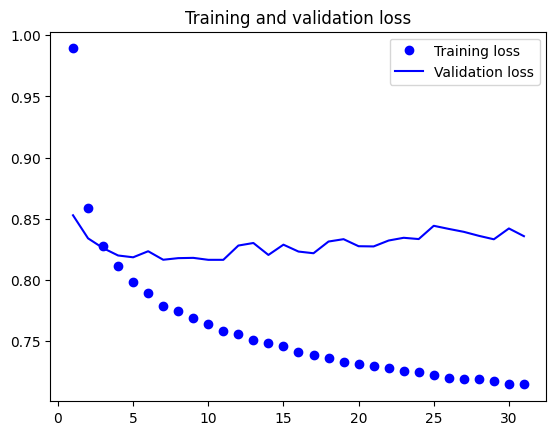

In [52]:
# Plot do Loss
epochs = range(1, len(history.history["loss"]) + 1 )
loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Grafico da accuracy:

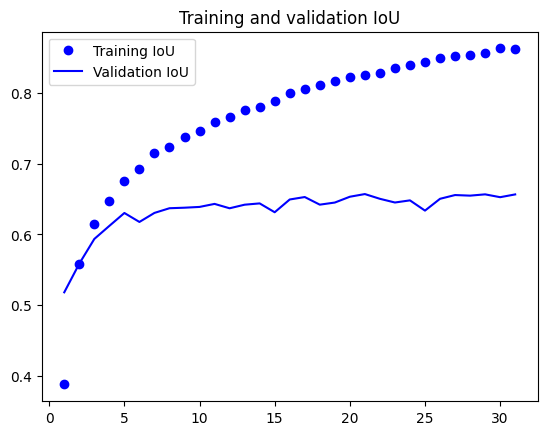

In [53]:
# Plot do Loss
#print(history.history)
epochs = range(1, len(history.history["val_iou_score"]) + 1)
iou = history.history["iou_score"]
val_iou = history.history["val_iou_score"]

plt.figure()
plt.plot(epochs, iou, "bo", label="Training IoU")
plt.plot(epochs, val_iou, "b", label="Validation IoU")
plt.title("Training and validation IoU")
plt.legend()
plt.show()

Evaluate:

In [5]:

custom_objects = {
    "dice_loss_plus_categorical_crossentropy": combined_loss,
    "DiceLoss": DiceLoss,
    "CategoricalCELoss": CategoricalCELoss,
    "iou_score": iou_score,
    "f1-score": f1_score
}

model = tf.keras.models.load_model("modeloUNetEfficientB6_LoveDA_SemAug1.keras",
                                   custom_objects=custom_objects)
#model.summary()

1/1 [==============================] - 9s 9s/step


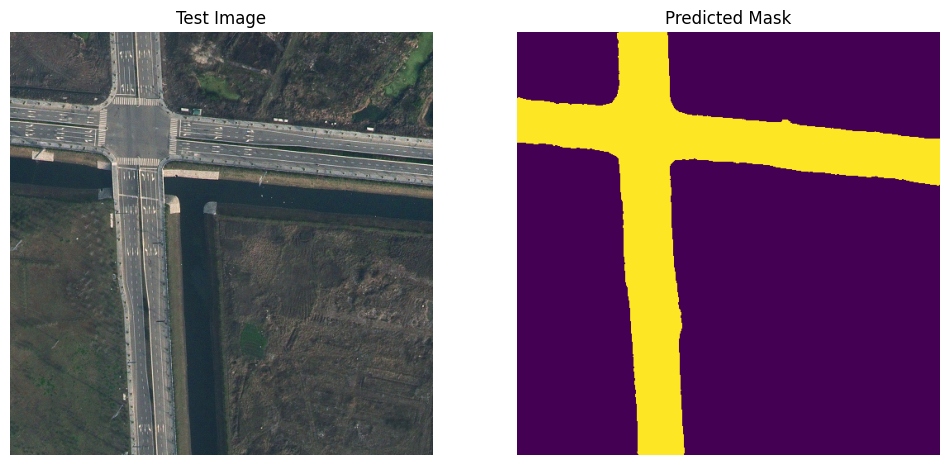

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image

# Carrega a imagem de teste
img = keras.utils.load_img(f"{input_dir}/test/images_original/466.png", target_size=img_size)

# Converte a imagem para array
img_array = keras.utils.img_to_array(img)
img_array = img_array / 255.0 #fazer o rescale
img_array = (img_array - imagenet_mean) / imagenet_std
img_array = np.expand_dims(img_array, axis=0)  # Adiciona a dimensão do batch

# Faz a predição
predictions = model.predict(img_array)
predictions = np.argmax(predictions, axis=3)[0,:,:] #remove a dimensao do batch

# Exibe a imagem de teste e a máscara predita lado a lado
plt.figure(figsize=(12, 6))

# Subplot 1: Exibe a imagem de teste
plt.subplot(1, 2, 1)
plt.title('Test Image')
plt.imshow(img)
plt.axis("off")

# Subplot 2: Exibe a máscara predita
plt.subplot(1, 2, 2)
plt.title('Predicted Mask')
plt.imshow(predictions)
plt.axis("off")

# Exibe os gráficos
plt.show()

mask = (predictions * 127).astype(np.uint8)  # Normaliza a máscara para valores entre 0 e 255

# Converte para uma imagem PIL
mask_img = Image.fromarray(mask)

# Salva a imagem
mask_img.save("mask.png")


1/1 [==============================] - 0s 78ms/step


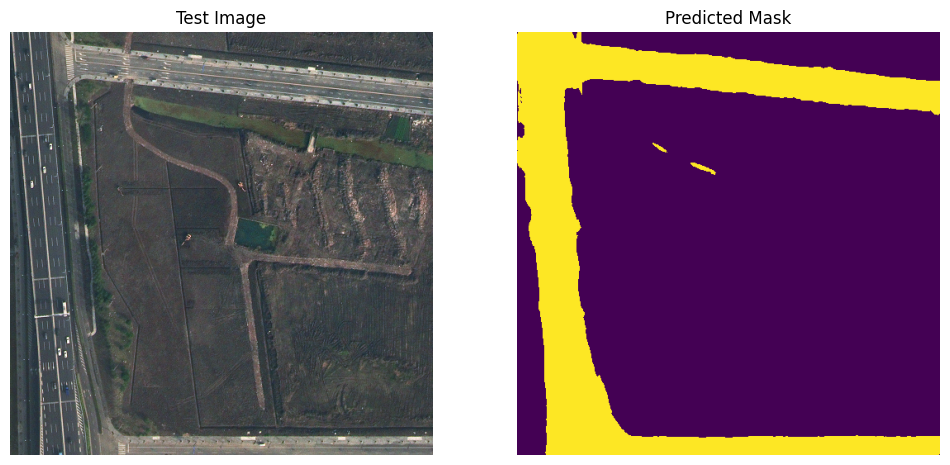

In [7]:

# Carrega a imagem de teste
img = keras.utils.load_img("Datasets/LoveDA/test/images/126.png", target_size=img_size)

# Converte a imagem para array
img_array = keras.utils.img_to_array(img)
img_array = img_array / 255.0 #fazer o rescale
img_array = (img_array - imagenet_mean) / imagenet_std
img_array = np.expand_dims(img_array, axis=0)  # Adiciona a dimensão do batch

# Faz a predição
predictions = model.predict(img_array)
predictions = np.argmax(predictions, axis=3)[0,:,:] #remove a dimensao do batch

# Exibe a imagem de teste e a máscara predita lado a lado
plt.figure(figsize=(12, 6))

# Subplot 1: Exibe a imagem de teste
plt.subplot(1, 2, 1)
plt.title('Test Image')
plt.imshow(img)
plt.axis("off")

# Subplot 2: Exibe a máscara predita
plt.subplot(1, 2, 2)
plt.title('Predicted Mask')
plt.imshow(predictions)
plt.axis("off")

# Exibe os gráficos
plt.show()

mask = (predictions * 127).astype(np.uint8)  # Normaliza a máscara para valores entre 0 e 255

# Converte para uma imagem PIL
mask_img = Image.fromarray(mask)

# Salva a imagem
mask_img.save("mask.png")

1/1 [==============================] - 0s 55ms/step


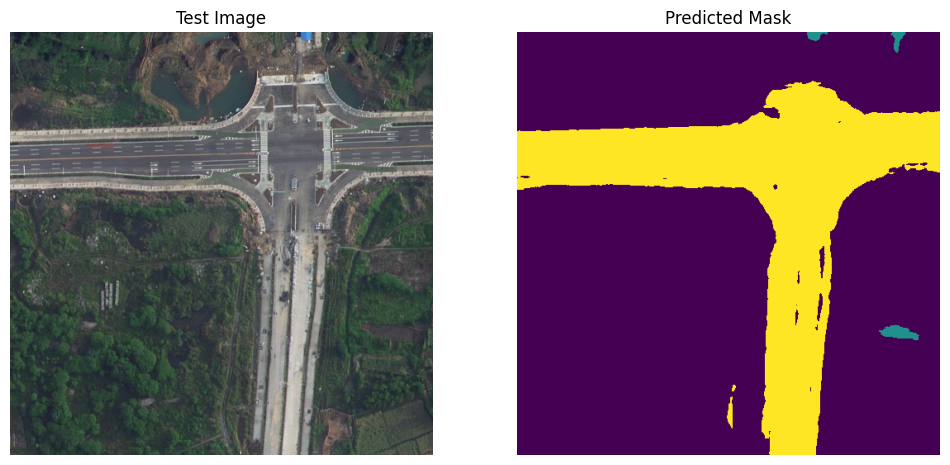

In [12]:
# Carrega a imagem de teste
img = keras.utils.load_img("Datasets/LoveDA/val/images/24.png", target_size=img_size)

# Converte a imagem para array
img_array = keras.utils.img_to_array(img)
img_array = img_array / 255.0 #fazer o rescale
img_array = (img_array - imagenet_mean) / imagenet_std
img_array = np.expand_dims(img_array, axis=0)  # Adiciona a dimensão do batch

# Faz a predição
predictions = model.predict(img_array)
predictions = np.argmax(predictions, axis=3)[0,:,:] #remove a dimensao do batch

# Exibe a imagem de teste e a máscara predita lado a lado
plt.figure(figsize=(12, 6))

# Subplot 1: Exibe a imagem de teste
plt.subplot(1, 2, 1)
plt.title('Test Image')
plt.imshow(img)
plt.axis("off")

# Subplot 2: Exibe a máscara predita
plt.subplot(1, 2, 2)
plt.title('Predicted Mask')
plt.imshow(predictions)
plt.axis("off")

# Exibe os gráficos
plt.show()

mask = (predictions * 127).astype(np.uint8)  # Normaliza a máscara para valores entre 0 e 255

# Converte para uma imagem PIL
mask_img = Image.fromarray(mask)

# Salva a imagem
mask_img.save("mask.png")

In [15]:
# Avaliação do modelo no conjunto de teste
(TotalLoss, IoU, f1_score) = model.evaluate(test_ds)  # Pegando todos os valores retornados
print("TotalLoss: ", TotalLoss)  # Isso imprimirá todos os valores retornados
print("IoU: ", IoU)  # Isso imprimirá todos os valores retornados
print("F1: ", f1_score)  # Isso imprimirá todos os valores retornados


746/746 [==============================] - 117s 156ms/step - loss: 1.4119 - iou_score: 0.3858 - f1-score: 0.5208
TotalLoss:  1.4118895530700684
IoU:  0.385800838470459
F1:  0.5208214521408081
